FTP do IBGE:

https://geoftp.ibge.gov.br/

Mapas:

https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/UFs/SC/

In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade pandas

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

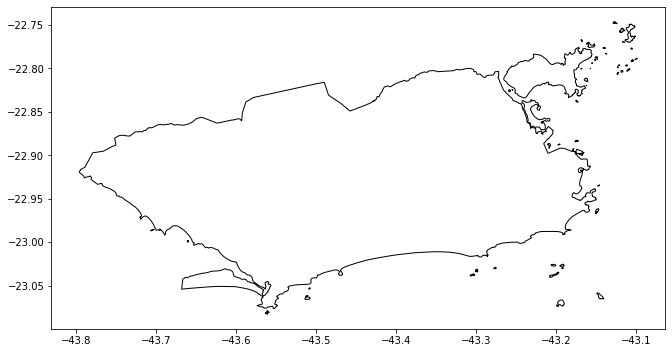

In [ ]:
# Mapa do município do Rio de Janeiro
path = '/content/drive/MyDrive/Programacao/GeoPandas/Mapas/RJ/33MUE250GC_SIR.shp'

rj = gpd.read_file(path)
rj = rj[rj['NM_MUNICIP'] == 'RIO DE JANEIRO']

rj.plot(color='white', edgecolor='black', figsize=(11,11))

In [ ]:
# Dados dos imóveis do município do Rio de Janeiro

path = '/content/drive/MyDrive/Programacao/GeoPandas/Dados/dados.txt'

dados = pd.read_table(path)
print(dados)

      Area                    Bairro  ... Transacao    Valor
0      138  Recreio dos Bandeirantes  ...     Venda  1095000
1      133   Freguesia (Jacarepaguá)  ...     Venda   650000
2       46                   Pilares  ...     Venda   150000
3       65           Barra da Tijuca  ...     Venda   430000
4       85                     Gávea  ...     Venda  1800000
...    ...                       ...  ...       ...      ...
4995    48              Campo Grande  ...     Venda   170000
4996    75  Recreio dos Bandeirantes  ...     Venda   550000
4997    32           Jardim Botânico  ...     Venda   580000
4998    85                    Grajaú  ...     Venda   325000
4999    52              Campo Grande  ...     Venda   135000

[5000 rows x 13 columns]


Agora, transformaremos o DataFrame em GeoDataFrame e as colunas Latitude e Longitude em Geometry.

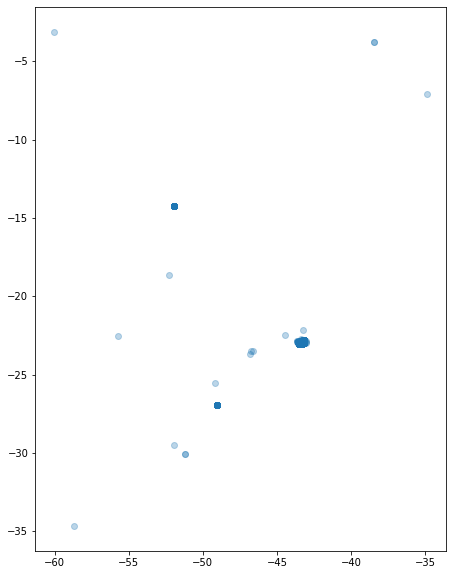

In [ ]:
localizacoes = zip(dados.Longitude, dados.Latitude) # iterador com as longitudes e latitudes
geometry = [Point(localizacao) for localizacao in localizacoes] # lista de Points com as localizações

crs = {'proj' : 'latlong',
       'ellps': 'WGS84',
       'datum' : 'WGS84',
       'no_defs' : True}

gdf_dados_imoveis = gpd.GeoDataFrame(dados, crs = crs, geometry = geometry)
gdf_dados_imoveis.plot(alpha=0.3, figsize=(8,10))

## CRS

Devemos equalizar o crs do GeoDataFrame rj e o gdf_dados para UTM.

Como estamos trabalhando com o RJ, sabemos que ele está na zona 23S da projeção UTM e o SIRGAS é utilziado para a América Latina. Podemos pesquisar o código em: 

www.spatialreference.org

Buscamos por Sirgas, existe o código EPSG:31983: SIRGAS 2000 / UTM zone 23S, que é a zona do RJ:

https://www.spatialreference.org/ref/epsg/31983/

Entrando no link proj4 temos o código da projeção:

https://www.spatialreference.org/ref/epsg/31983/proj4/

    +proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 

Esse código será utlizado para setar o crs dos dois GeoDataFrames:


In [ ]:
print(rj.crs)
print(gdf_dados_imoveis.crs)

epsg:4674
+proj=latlong +ellps=WGS84 +datum=WGS84 +no_defs +type=crs


In [ ]:
rj = rj.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')
gdf_dados_imoveis = gdf_dados_imoveis.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

In [ ]:
print(rj.crs)
print(gdf_dados_imoveis.crs)

+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs +type=crs
+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs +type=crs


In [ ]:
print(rj)

      ID  ...                                           geometry
67  1535  ...  MULTIPOLYGON (((692.576 7476.609, 692.572 7476...

[1 rows x 4 columns]


Agora, os dados Geometry não estão mais em Latitude e Longitude, e sim em Km. Dessa forma, podemos medir as distâncias entre os pontos.

Com os dados seguindo o mesmo padrão, podemos partir para os outliers, que são pontos fora do nosso interesse. No caso, são pontos fora do município do RJ.

## Selecionando pontos dentro de uma região

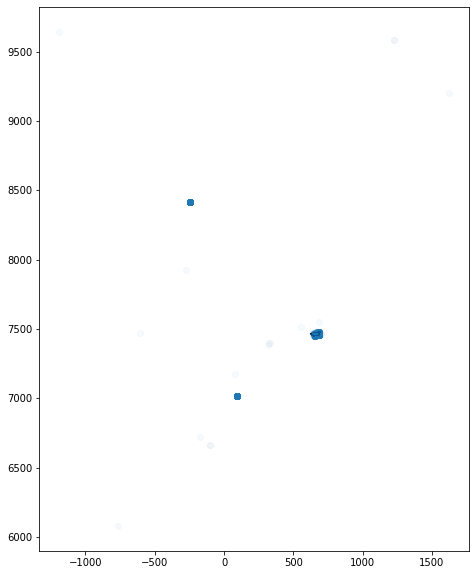

In [ ]:
base = rj.plot(color='white', edgecolor='black', figsize=(10,10))
gdf_dados_imoveis.plot(ax = base, figsize=(10,10), alpha = 0.03)

Podemos ver que a maior concentração de pontos é na coordenada (600, 7500), e que atrás dessa concentração se encontra o mapa do município do RJ. Porém, existem diversos pontos fora da cidade. Devemos removê-los.

In [ ]:
rj.iloc[0]

ID                                                         1535
CD_GEOCODM                                              3304557
NM_MUNICIP                                       RIO DE JANEIRO
geometry      (POLYGON ((692.5758012880638 7476.609203982483...
Name: 67, dtype: object

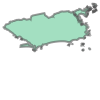

In [ ]:
rj.iloc[0].geometry

In [ ]:
gdf_dados_imoveis.iloc[0]

Area                                                 138
Bairro                          Recreio dos Bandeirantes
Cidade                                    Rio de Janeiro
Endereco                             Rua Vicente Scofano
Estado                                                RJ
Latitude                                      -23.016455
Longitude                                     -43.462946
Quartos                                                3
Suites                                                 1
Vagas                                                  3
Tipo                                         Apartamento
Transacao                                          Venda
Valor                                            1095000
geometry     POINT (657.5137068691058 7453.832425203198)
Name: 0, dtype: object

Para fazer isso, devemos pegar ponto por ponto e verificar se ele está dentro dos limites do município. Vamos testar para o primeiro ponto:

In [ ]:
gdf_dados_imoveis.iloc[0].geometry.within(rj.iloc[0].geometry)

# ou
# rj.iloc[0].geometry.contains(gdf_dados_imoveis.iloc[0])

True

Agora, fazemos isso para todos os pontos:

In [ ]:
esta_dentro = gdf_dados_imoveis['geometry'].within(rj.iloc[0].geometry)
esta_dentro ## Series mostrando se cada ponto está dentro dos limites do município

0        True
1        True
2        True
3        True
4       False
        ...  
4995     True
4996     True
4997     True
4998     True
4999     True
Length: 5000, dtype: bool

In [ ]:
gdf_dados_imoveis = gdf_dados_imoveis[esta_dentro] ## Seleção apenas dos pontos dentro do limite do município
gdf_dados_imoveis

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor,geometry
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000,POINT (657.514 7453.832)
1,133,Freguesia (Jacarepaguá),Rio de Janeiro,Rua Potiguara,RJ,-22.943199,-43.336911,3,1,2,Apartamento,Venda,650000,POINT (670.524 7461.803)
2,46,Pilares,Rio de Janeiro,Rua Professor Carneiro Felipe,RJ,-22.873849,-43.300517,1,0,0,Apartamento,Venda,150000,POINT (674.345 7469.440)
3,65,Barra da Tijuca,Rio de Janeiro,Avenida Salvador Allende,RJ,-22.984787,-43.412703,2,1,1,Apartamento,Venda,430000,POINT (662.701 7457.284)
5,260,Recreio dos Bandeirantes,Rio de Janeiro,Rua Desembargador Paulo Alonso,RJ,-23.018927,-43.477505,3,1,2,Apartamento,Venda,1160000,POINT (656.019 7453.574)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,48,Campo Grande,Rio de Janeiro,Rua Josué de Barros,RJ,-22.878349,-43.550762,2,0,1,Apartamento,Venda,170000,POINT (648.664 7469.216)
4996,75,Recreio dos Bandeirantes,Rio de Janeiro,Rua Le Corbusier,RJ,-23.024717,-43.487285,3,1,1,Apartamento,Venda,550000,POINT (655.010 7452.944)
4997,32,Jardim Botânico,Rio de Janeiro,Rua Getúlio das Neves,RJ,-22.959433,-43.206180,1,0,0,Apartamento,Venda,580000,POINT (683.909 7459.848)
4998,85,Grajaú,Rio de Janeiro,Rua Jerônimo de Lemos,RJ,-22.918773,-43.260492,3,0,0,Apartamento,Venda,325000,POINT (678.393 7464.417)


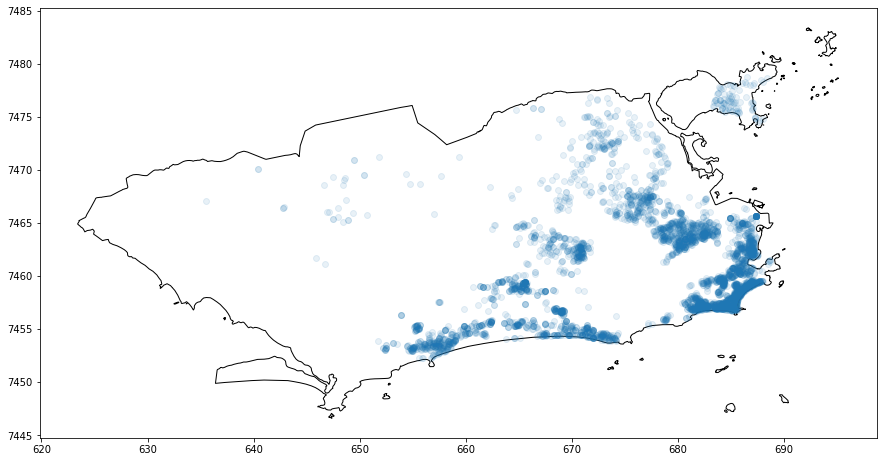

In [ ]:
base = rj.plot(color='white', edgecolor='black', figsize=(15,15))
gdf_dados_imoveis.plot(ax = base, figsize=(15,15), alpha = 0.1)

## Obtendo distâncias

Como estamos lidando com imóveis no RJ, o valor do imóvel está diretamente ligado a sua localização e também aos serviços em seu entorno. Vamos adicionar as **estações de metrô** para posteriormente calcular os valores dos imóveis.

www.data.rio

https://www.data.rio/datasets/PCRJ::esta%C3%A7%C3%B5es-metr%C3%B4/about

In [ ]:
metro = gpd.read_file('/content/drive/MyDrive/Programacao/GeoPandas/Dados/Estacoes_Metro.geojson')
metro.head()

,OBJECTID,Cod,Nome,Flg_ATM,Flg_Bicicletario,Flg_Elevador,Flg_Linha1,Flg_Linha2,Obs,Flg_Ativa,Status,Data_Inc,Flg_Linha4,Integra_Trem,Integra_Onibus,Integra_BRT,Corredor,Integra_VLT,Onibus,Flg_Metro_Superficie,Metro_Superficie,Data_Inauguracao,geometry
0,1,1,Pavuna,1,1.0,1.0,0,1,None,1,None,None,0,1,0,0,None,0,None,0,None,1998,POINT (-43.36485 -22.80662)
1,2,2,Engenheiro Rubens Paiva,1,1.0,1.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.35845 -22.81627)
2,3,3,Acari / Fazenda Botafogo,0,0.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.34964 -22.82452)
3,4,4,Coelho Neto,1,0.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.34326 -22.83148)
4,5,5,Colégio,1,1.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.33386 -22.84269)


In [ ]:
# Alteração do CRS para ficar igual aos demais dados (mapa e imóveis)

metro = metro.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

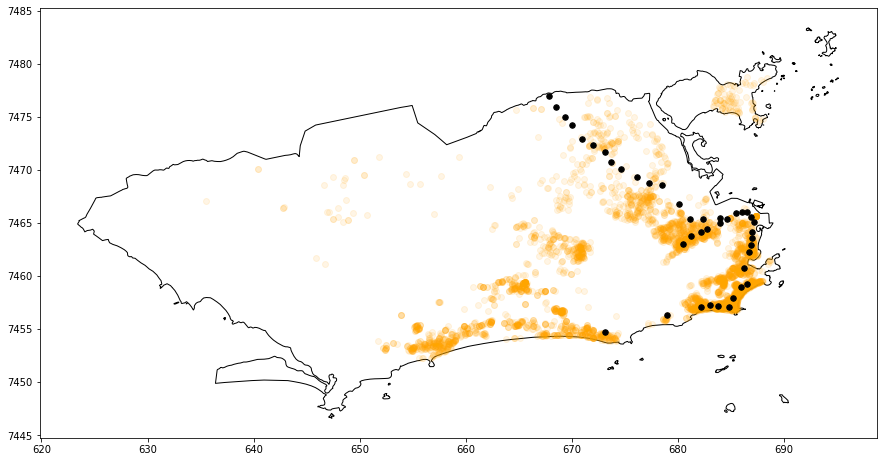

In [ ]:
# Plot das 3 camadas (mapa, imíveis e metro)

base = rj.plot(color='white', edgecolor='black', figsize=(15,15))
gdf_dados_imoveis.plot(ax = base, color='orange', figsize=(15,15), alpha = 0.1)
metro.plot(ax = base, color='black', figsize=(15,15), markersize=30)

Continua na Parte 3.